In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import defaultdict
from sklearn.model_selection import train_test_split


# Suppress TensorFlow log messages to keep the output clean
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set TensorFlow logger to only show error messages
tf.get_logger().setLevel('ERROR')

EPOCHS          = 100           # Number of training epochs
IMG_WIDTH       = 30            # Width of the input images
IMG_HEIGHT      = 30            # Height of the input images
NUM_CATEGORIES  = 43            # Number of categories (classes) in the dataset
TEST_SIZE       = 0.2           # Proportion of the dataset to include in the test split

data_dir    = 'data/gtsrb'                  # Directory containing the dataset
model_path  = 'models/best_model.keras'     # Path to save the best model


2024-07-30 15:48:28.060338: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 15:48:28.083565: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 15:48:28.134755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 15:48:28.194644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 15:48:28.212012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 15:48:28.280991: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def load_and_preprocess_data(data_dir):
    """
    Load images from a directory, preprocess them by resizing and normalizing, and return the images and their labels.

    Parameters:
    data_dir (str): Path to the directory containing subdirectories of images. Each subdirectory should be named 
                    with an integer label and contain the corresponding images.

    Returns:
    np.ndarray: Array of preprocessed images.
    np.ndarray: Array of labels corresponding to the images.
    """
    images = []
    labels = []

    # Iterate over each folder in the data directory
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        
        # Skip if it's not a directory
        if not os.path.isdir(folder_path):
            continue

        # Convert folder name to integer label
        label = int(folder)
        
        # Iterate over each file in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            
            # Check if the file is an image
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
                image = cv2.imread(file_path)
                
                if image is not None:
                    # Resize the image to the desired dimensions
                    resized_image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                    
                    # Normalize the image
                    preprocessed_image = resized_image / 255.0
                    
                    # Append the preprocessed image and label to the lists
                    images.append(preprocessed_image)
                    labels.append(label)

    # Print the total number of labels and unique labels
    print(f"Total labels loaded: {len(labels)}")
    print(f"Unique labels: {set(labels)}")

    return np.array(images), np.array(labels)

In [3]:
def preprocess_image(image):
    """
    Preprocess a single image by resizing it to the desired dimensions, normalizing the pixel values,
    and adding a batch dimension.

    Parameters:
    image (np.ndarray): The input image to preprocess.

    Returns:
    np.ndarray: The preprocessed image with an added batch dimension.
    """
    # Resize the image to the desired dimensions
    resized_image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    
    # Normalize the image by scaling pixel values to the range [0, 1]
    preprocessed_image = resized_image / 255.0
    
    # Add a batch dimension to the image
    return np.expand_dims(preprocessed_image, axis=0)


In [4]:
def predict_image(model, image):
    """
    Predict the class of a single preprocessed image using a trained model.

    Parameters:
    model (keras.Model): The trained model used for making the prediction.
    image (np.ndarray): The preprocessed image to predict.

    Returns:
    int: The predicted class label for the input image.
    """
    # Use the model to predict the class probabilities of the input image
    prediction = model.predict(image)
    
    # Return the index of the class with the highest probability
    return np.argmax(prediction, axis=1)[0]


In [5]:
def load_trained_model(model_path):
    """
    Load a trained model from the specified file path.

    Parameters:
    model_path (str): Path to the saved model file.

    Returns:
    keras.Model: The loaded trained model.
    """
    # Load and return the trained model from the specified path
    return keras.models.load_model(model_path)


In [6]:
def get_model():
    """
    Returns a compiled convolutional neural network model.

    The model architecture includes:
    - Three convolutional layers with increasing filter sizes and ReLU activation.
    - Max pooling layers after each convolutional layer to reduce spatial dimensions.
    - Batch normalization layers to stabilize and accelerate training.
    - A flatten layer to convert the 3D outputs to 1D vectors.
    - A dense (fully connected) layer with ReLU activation and L2 regularization.
    - A dropout layer to prevent overfitting.
    - An output dense layer with softmax activation for classification into NUM_CATEGORIES classes.

    Returns:
        model (tf.keras.Model): Compiled Keras model ready for training.
    """
    model = keras.Sequential([
        # Input layer with shape (IMG_WIDTH, IMG_HEIGHT, 3)
        keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),

        # First convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        # Max pooling layer with 2x2 pool size to reduce spatial dimensions
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # Batch normalization to stabilize and speed up training
        tf.keras.layers.BatchNormalization(),
        
        # Second convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        # Max pooling layer with 2x2 pool size
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # Batch normalization
        tf.keras.layers.BatchNormalization(),
        
        # Third convolutional layer with 256 filters, 3x3 kernel size, and ReLU activation
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
        # Max pooling layer with 2x2 pool size
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # Batch normalization
        tf.keras.layers.BatchNormalization(),
        
        # Flatten layer to convert 3D outputs to 1D vectors
        tf.keras.layers.Flatten(),
        # Dense layer with 512 units, ReLU activation, and L2 regularization
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        # Dropout layer with 0.5 rate to prevent overfitting
        tf.keras.layers.Dropout(0.5),
        # Output layer with NUM_CATEGORIES units and softmax activation for classification
        tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
    ])

    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy'],
    )

    return model


In [7]:
def plot_training_history(history):
    """
    Plots the training history of the model, including accuracy and loss for both training and validation sets.

    Parameters:
        history (tf.keras.callbacks.History): History object returned by the fit method of a Keras model. It contains
                                              training and validation loss and accuracy for each epoch.

    The function creates two subplots:
    - The first subplot shows the accuracy over epochs for both training and validation data.
    - The second subplot shows the loss over epochs for both training and validation data.
    """
     # Set the figure size for the plots
    plt.figure(figsize=(12, 4))

    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Train')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Display the plots
    plt.show()


In [8]:
def print_final_results(model, x_test, y_test):
    """
    Evaluate the model on the test dataset and print the final loss and accuracy.

    Parameters:
        model (tf.keras.Model): The trained Keras model to evaluate.
        x_test (numpy.ndarray): The test data, features.
        y_test (numpy.ndarray): The test data, labels.

    The function evaluates the model using the test data and prints the final loss and accuracy.
    """
    # Evaluate the model on the test data and obtain the loss and accuracy
    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)

    # Print the final loss and accuracy with four decimal places
    print(f"Final loss: {loss:.2f}")
    print(f"Final accuracy: {accuracy * 100:.2f}%")


In [9]:
class CustomCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to stop training when a specified condition is met.

    This callback stops training if the validation accuracy reaches 100%.

    Methods:
        on_epoch_end(epoch, logs=None): Checks validation accuracy at the end of each epoch and stops training if it reaches 100%.
    """
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch during training.

        Parameters:
            epoch (int): The index of the epoch.
            logs (dict, optional): Contains metrics and their values for the epoch.

        If the validation accuracy (`val_categorical_accuracy`) reaches 100%, training is stopped.
        """
        if logs.get('val_categorical_accuracy') == 1.0:
            print(f"Reached 100% accuracy so stopping training!")
            self.model.stop_training = True


Total labels loaded: 26425
Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}
Epoch 1/100


I0000 00:00:1722343722.184216  328052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-30 15:48:42.185246: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


   3/1322 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - categorical_accuracy: 0.0625 - loss: 5.4874

/home/razvansavin/miniconda3/envs/.conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1320/1322 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.4462 - loss: 2.9694
Epoch 1: val_loss improved from inf to 0.94430, saving model to models/best_model.keras
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - categorical_accuracy: 0.4467 - loss: 2.9670 - val_categorical_accuracy: 0.8780 - val_loss: 0.9443 - learning_rate: 0.0010
Epoch 2/100
1320/1322 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.8948 - loss: 0.8633
Epoch 2: val_loss improved from 0.94430 to 0.66151, saving model to models/best_model.keras
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - categorical_accuracy: 0.8948 - loss: 0.8631 - val_categorical_accuracy: 0.9307 - val_loss: 0.6615 - learning_rate: 0.0010
Epoch 3/100
1320/1322 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.9333 - loss: 0.6290
Epoch 3: val_loss improved from 0.66151 to 0.50816, saving model to models/best_model.keras
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - categorical_accuracy: 0.9333 - loss: 0.6289 - val

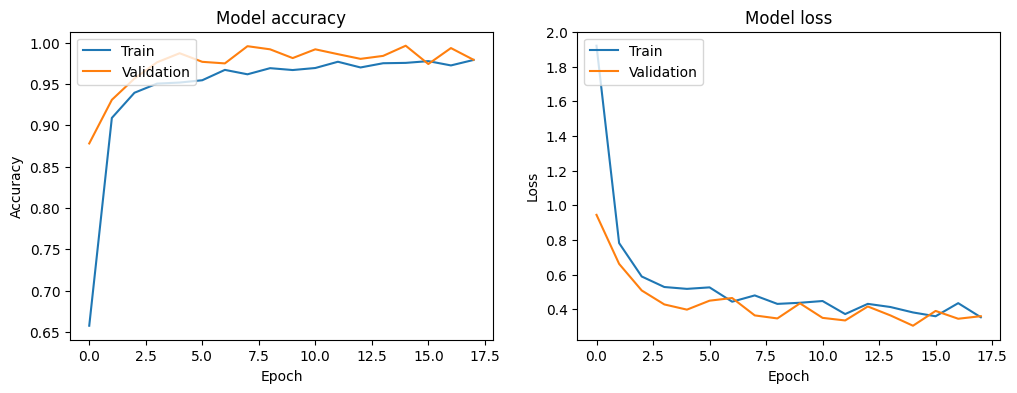

166/166 - 1s - 8ms/step - categorical_accuracy: 0.9956 - loss: 0.3643
Final loss: 0.36
Final accuracy: 99.56%


In [10]:
def main(data_dir, model_path):
    """
    Main function to load data, preprocess it, train a model, and evaluate the results.

    Parameters:
    data_dir (str): Path to the directory containing the dataset.
    model_path (str): Path to save the trained model.
    """
    # Load and preprocess the data
    images, labels = load_and_preprocess_data(data_dir)
    
    # Check if images or labels are empty
    if len(images) == 0 or len(labels) == 0:
        print("No images or labels found. Please check the data directory.")
        return

    # Convert labels to categorical format
    labels = tf.keras.utils.to_categorical(labels, NUM_CATEGORIES)
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        np.array(images), np.array(labels), test_size=TEST_SIZE
    )

    # Create an image data generator for data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False
    )
    datagen.fit(x_train)

    # Get the model
    model = get_model()

    # Define callbacks for training
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy', min_delta=0.001, patience=10, mode='max', 
        verbose=1, restore_best_weights=True
    )
    
    lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.001, 
        cooldown=1, min_lr=1e-6
    )

    custom_callback = CustomCallback()

    # Train the model
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=16), 
        epochs=EPOCHS, 
        validation_data=(x_test, y_test), 
        callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler_callback, custom_callback]
    )

    # Plot the training history
    plot_training_history(history)

    # Print the final results
    print_final_results(model, x_test, y_test)

# Call the main function with the appropriate data directory and model path
main(data_dir, model_path)


---
5 Predictions for each label, used files that I moved in other folder to see how models perform

In [14]:
IMG_PREDICTIONS_PER_FOLDER = 5

# Moved 5 files (each category) from the GTSRB dataset in another folder to use trained model on them to see if performs well
data_dir = 'data/gtsrb-test-files' 

def load_and_preprocess_data(data_dir, num_images_per_label=1):
    """
    Load images from a directory, preprocess them by resizing and normalizing, and return the images and their labels.
    Limits the number of images per label to a specified number.

    Parameters:
    data_dir (str): Path to the directory containing subdirectories of images. Each subdirectory should be named 
                    with an integer label and contain the corresponding images.
    num_images_per_label (int): The maximum number of images to load per label. Default is 1 (minimum).

    Returns:
    np.ndarray: Array of preprocessed images.
    np.ndarray: Array of labels corresponding to the images.
    """
    images = []
    labels = []
    label_count = defaultdict(int)

    # Iterate over each folder in the data directory
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        
        # Skip if it's not a directory
        if not os.path.isdir(folder_path):
            continue

        # Convert folder name to integer label
        label = int(folder)
        
        # Iterate over each file in the folder
        for file in os.listdir(folder_path):
            # Stop if the number of images for this label reaches the limit
            if label_count[label] >= num_images_per_label:
                break

            file_path = os.path.join(folder_path, file)
            
            # Check if the file is an image
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
                image = cv2.imread(file_path)
                
                if image is not None:
                    # Resize the image to the desired dimensions
                    resized_image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                    
                    # Normalize the image
                    preprocessed_image = resized_image / 255.0
                    
                    # Append the preprocessed image and label to the lists
                    images.append(preprocessed_image)
                    labels.append(label)
                    label_count[label] += 1

    print(f"Load images from directory: '{data_dir}'.")
    print(f"Total images loaded: {len(images)}")
    print(f"Unique labels: {set(labels)}")

    return np.array(images), np.array(labels)


# Load the trained model
model = load_trained_model(model_path)

# Load and preprocess the entire dataset with a limit of 10 images per label
images, true_labels = load_and_preprocess_data(data_dir, num_images_per_label=IMG_PREDICTIONS_PER_FOLDER)

# Initialize counters for correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

# Make predictions on the dataset
for i, image in enumerate(images):
    preprocessed_image = np.expand_dims(image, axis=0)  # Already normalized during loading
    prediction = predict_image(model, preprocessed_image)
    if prediction == true_labels[i]:
        correct_predictions += 1
    else:
        incorrect_predictions += 1
    print(f"True class: {true_labels[i]} - Predicted class: {prediction}")

# Print the count of correct and incorrect predictions
total_predictions = correct_predictions + incorrect_predictions
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")
print(f"Accuracy: {accuracy_percentage:.2f}%")


Load images from directory: 'data/gtsrb-test-files'.
Total images loaded: 215
Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
True class: 30 - Predicted class: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
True class: 30 - Predicted class: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True class: 30 - Predicted class: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True class: 30 - Predicted class: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True class: 30 - Predicted class: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True class: 29 - Predicted class: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True class: 29 - Predicted class: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True class: 29 - Predicted class: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True class: 29 - Predicted class: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True class: 29 - Predicted clas

---